![vgu_campus.png](..\images\fscampus_small2.png)

***Finance III (PFIN)-SS2025***

**Dr. Omer Cayirli**

Lecturer in Empirical Finance

omer.cayirli@vgu.edu.vn

---

## Lecture 05
---

### Outline

* Optimal capital structure

* Alternative capital structure theories
---

### Optimal Capital Structure with Taxes
* Do firms prefer debt?
    * The use of leverage varies greatly by industry.
    * Many firms retain large cash balances to reduce their effective leverage.
        * Growth industries
        * Utilities, real estate development
    * Since taxes favor debt for most firms, should all firms be 100% debt financed?
    * Why don't all firms lever up and save on corporate taxes?

---

🔑 Successfully retrieved FRED_API_KEY from environment variable.
--- ⚙️ Starting Data Fetch and Processing ---

--- 📊 Final Annual Data for Plot (Starting 1980) ---
            Nonfinancial Corp; Total Debt as % of Equity (Percent, NSA)  \
date                                                                      
2020-12-31                                         100.950312             
2021-12-31                                          82.512794             
2022-12-31                                          89.623670             
2023-12-31                                          89.858037             
2024-12-31                                          87.756080             

            Capital Expenditures (Real 2014 Billions, SAAR)  \
date                                                          
2020-12-31                                     1.851312e+06   
2021-12-31                                     1.964929e+06   
2022-12-31                                     2.283029e+

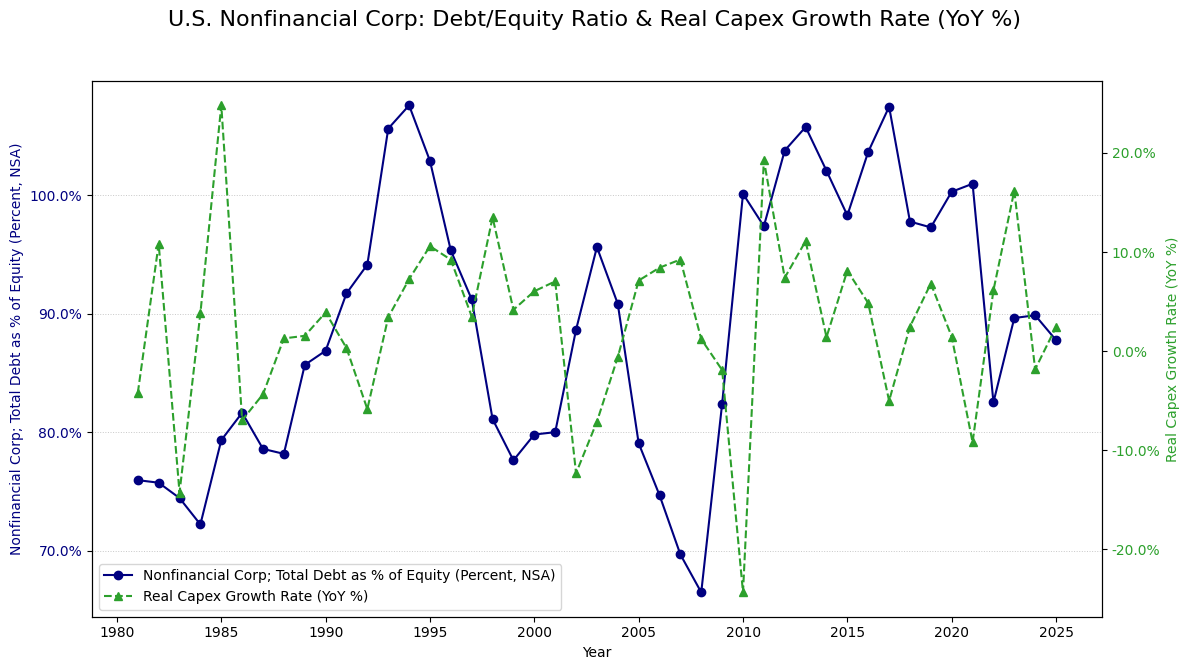


--- ✅ Script Finished ---


In [2]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import sys # Added sys for cleaner exit if needed

# --- Configuration ---
FRED_API_KEY = os.environ.get('FRED_API_KEY')

if not FRED_API_KEY:
    print("⚠️ Error: FRED_API_KEY environment variable not set.")
    # Fallback to input if not in environment (optional, can be removed if env var is always set)
    try:
        print("Please set the FRED_API_KEY environment variable.")
        FRED_API_KEY = input("Or enter your FRED API Key now (typing will be visible): ")
        if not FRED_API_KEY:
            print("No API key provided. Exiting.")
            sys.exit()
        else:
            print("🔑 Using API key provided at runtime.")
    except Exception as e:
        print(f"Error during API key input: {e}. Exiting.")
        sys.exit()
else:
    print("🔑 Successfully retrieved FRED_API_KEY from environment variable.")

BASE_URL = 'https://api.stlouisfed.org/fred/series/observations'

SERIES_DETAILS = {
    'debt_to_equity_ratio': {
        'id': 'BOGZ1FL010000286Q',
        'name': 'Nonfinancial Corp; Total Debt as % of Equity',
        'unit_multiplier': 1.0
    },
    'capex_flow_saar': {
        'id': 'BOGZ1FA105050005Q',
        'name': 'Nonfinancial Corp; Capital Expenditures',
        'unit_multiplier': 1.0
    },
    'gdp_deflator': {'id': 'GDPDEF', 'name': 'GDP Deflator', 'unit_multiplier': 1.0}
}

START_DATE_API = '1979-01-01'
PLOT_START_YEAR = 1980
BASE_YEAR = 2014
OUTPUT_DATA_DIR = "data"

# --- Function to Fetch Data from FRED API ---
def fetch_fred_series(series_id, series_name_desc, api_key, start_date):
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
    }
    # Minimal print: only if fetching
    # print(f"Fetching {series_name_desc} ({series_id})...") 
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        if 'observations' not in data or not data['observations']:
            print(f"📉 Warning: No observations found for {series_name_desc} ({series_id}).")
            return pd.Series(dtype='float64', name=series_id)

        df = pd.DataFrame(data['observations'])
        if df.empty:
             print(f"📉 Warning: Observations array was empty for {series_name_desc} ({series_id}).")
             return pd.Series(dtype='float64', name=series_id)

        df = df[['date', 'value']]
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df['value'] = pd.to_numeric(df['value'], errors='coerce')

        # Minimal success print
        # print(f"✅ Successfully fetched {series_name_desc} ({series_id}).")
        return df['value'].rename(series_name_desc)

    except requests.exceptions.HTTPError as http_err:
        print(f"❌ HTTP error fetching {series_name_desc} ({series_id}): {http_err}")
        try:
            error_content = response.json()
            print(f"FRED API Error Details: {error_content.get('error_message', 'No specific error message.')}")
        except ValueError:
            print(f"FRED API Error Response (not JSON): {response.text}")
    except Exception as e:
        print(f"❌ An unexpected error occurred for {series_name_desc} ({series_id}): {e}")
    return pd.Series(dtype='float64', name=series_id)

# --- Main Data Processing ---
print("--- ⚙️ Starting Data Fetch and Processing ---")
fetched_series_map = {}
for key, details in SERIES_DETAILS.items():
    series_data = fetch_fred_series(
        details['id'],
        details['name'],
        FRED_API_KEY,
        START_DATE_API
    )
    fetched_series_map[key] = series_data

gdp_deflator_data_raw = fetched_series_map.get('gdp_deflator')
capex_data_raw = fetched_series_map.get('capex_flow_saar')
debt_to_equity_data_raw = fetched_series_map.get('debt_to_equity_ratio')

real_capex_level_col_name = f'Capital Expenditures (Real {BASE_YEAR} Billions, SAAR)'
real_capex_growth_col_name = f'Real Capex Growth Rate (YoY %)'
debt_to_equity_col_name_ref = SERIES_DETAILS['debt_to_equity_ratio']['name']
debt_to_equity_col_name_plot = debt_to_equity_col_name_ref + " (Percent, NSA)"

if gdp_deflator_data_raw is None or gdp_deflator_data_raw.empty or gdp_deflator_data_raw.isnull().all():
    print("❌ Critical error: GDP Deflator could not be fetched or is empty. Exiting.")
    sys.exit()

real_capex_level = pd.Series(dtype='float64', name=real_capex_level_col_name)
if capex_data_raw is None or capex_data_raw.empty or capex_data_raw.isnull().all():
    print(f"📉 Warning: {SERIES_DETAILS['capex_flow_saar']['name']} data could not be fetched or is empty.")
else:
    temp_df_for_capex_deflation = pd.concat([capex_data_raw.rename('capex_nominal'), gdp_deflator_data_raw.rename('gdp_deflator')], axis=1)
    temp_df_for_capex_deflation.dropna(subset=['capex_nominal', 'gdp_deflator'], inplace=True)

    if not temp_df_for_capex_deflation.empty:
        if any(year == BASE_YEAR for year in temp_df_for_capex_deflation.index.year):
            gdp_deflator_base_period_values = temp_df_for_capex_deflation['gdp_deflator'][str(BASE_YEAR)]
            if not (gdp_deflator_base_period_values.empty or gdp_deflator_base_period_values.isnull().all()):
                gdp_deflator_base_period_mean = gdp_deflator_base_period_values.mean()
                if not (pd.isna(gdp_deflator_base_period_mean) or gdp_deflator_base_period_mean == 0):
                    temp_df_for_capex_deflation['gdp_deflator_rebased'] = (temp_df_for_capex_deflation['gdp_deflator'] / gdp_deflator_base_period_mean) * 100
                    real_capex_level_values = (temp_df_for_capex_deflation['capex_nominal'] / temp_df_for_capex_deflation['gdp_deflator_rebased']) * 100
                    real_capex_level = real_capex_level_values.rename(real_capex_level_col_name)
                # else: print(f"📉 Warning: Could not calculate valid mean GDP deflator for {BASE_YEAR}.") # Optional
            # else: print(f"📉 Warning: GDP Deflator values for {BASE_YEAR} (common range) are NaN or empty.") # Optional
        # else: print(f"📉 Warning: GDP Deflator for {BASE_YEAR} not in common Capex range.") # Optional
    # else: print("📉 Warning: No overlapping Capex/GDP Deflator data.") # Optional


debt_to_equity_ratio = pd.Series(dtype='float64', name=debt_to_equity_col_name_plot)
if debt_to_equity_data_raw is None or debt_to_equity_data_raw.empty or debt_to_equity_data_raw.isnull().all():
    print(f"📉 Warning: {debt_to_equity_col_name_ref} data is unavailable or empty.")
else:
    debt_to_equity_ratio = debt_to_equity_data_raw.rename(debt_to_equity_col_name_plot)

final_plot_data_quarterly = pd.concat([debt_to_equity_ratio, real_capex_level], axis=1)

# Minimal print before annual data
# print("\n--- Quarterly Data before Annual Resampling ---")
# print(final_plot_data_quarterly.tail())

if final_plot_data_quarterly.empty or not isinstance(final_plot_data_quarterly.index, pd.DatetimeIndex) or len(final_plot_data_quarterly.index) == 0:
    print("📉 Quarterly data for plot is empty or has an invalid index. Skipping annual calculation.")
    final_plot_data_annual = pd.DataFrame()
else:
    final_plot_data_annual = final_plot_data_quarterly.resample('YE').mean()
    if real_capex_level_col_name in final_plot_data_annual and final_plot_data_annual[real_capex_level_col_name].notna().any():
        if len(final_plot_data_annual[real_capex_level_col_name].dropna()) >= 2:
            final_plot_data_annual[real_capex_growth_col_name] = final_plot_data_annual[real_capex_level_col_name].pct_change(periods=1) * 100
        else:
            final_plot_data_annual[real_capex_growth_col_name] = pd.NA
    else:
        final_plot_data_annual[real_capex_growth_col_name] = pd.NA
    final_plot_data_annual = final_plot_data_annual[final_plot_data_annual.index.year >= PLOT_START_YEAR].copy()
    
    print(f"\n--- 📊 Final Annual Data for Plot (Starting {PLOT_START_YEAR}) ---")
    print(final_plot_data_annual.tail())

    if not final_plot_data_annual.empty:
        last_year_end_data = final_plot_data_annual.iloc[-1:]
        if not last_year_end_data.empty :
            last_year_date = last_year_end_data.index[0].strftime('%Y-%m-%d')
            print(f"\n--- Data for Most Recent Complete Year End ({last_year_date}) ---")
            print(last_year_end_data)

if not final_plot_data_annual.empty:
    try:
        if not os.path.exists(OUTPUT_DATA_DIR):
            os.makedirs(OUTPUT_DATA_DIR)
            # print(f"Created output directory: {OUTPUT_DATA_DIR}") # Optional
        csv_filename_base = 'python_nonfinancial_corp_debt_equity_real_capex_growth_annual.csv'
        csv_filepath = os.path.join(OUTPUT_DATA_DIR, csv_filename_base)
        series_to_save = [col for col in [debt_to_equity_col_name_plot, real_capex_growth_col_name] if col in final_plot_data_annual and final_plot_data_annual[col].notna().any()]
        if series_to_save:
             final_plot_data_annual[series_to_save].to_csv(csv_filepath)
             print(f"\n💾 Annual data for plot saved to: {csv_filepath}")
        # else: print("\nNo columns with data to save to CSV.") # Optional
    except Exception as e:
        print(f"❌ Error saving data to CSV: {e}")

    # print(f"\n--- Generating Plot (Annual Data starting {PLOT_START_YEAR}) ---") # Optional
    if final_plot_data_annual.notna().any().any():
        fig, ax1 = plt.subplots(figsize=(12, 7))
        plot_title_main = f'U.S. Nonfinancial Corp: Debt/Equity Ratio & Real Capex Growth Rate (YoY %)'
        color_de = 'navy'

        plotted_de = False
        if debt_to_equity_col_name_plot in final_plot_data_annual and final_plot_data_annual[debt_to_equity_col_name_plot].notna().any():
            ax1.set_xlabel('Year')
            ax1.set_ylabel(debt_to_equity_col_name_plot, color=color_de)
            ax1.plot(final_plot_data_annual.index, final_plot_data_annual[debt_to_equity_col_name_plot], color=color_de, label=debt_to_equity_col_name_plot, marker='o', linestyle='-')
            ax1.tick_params(axis='y', labelcolor=color_de)
            ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f%%'))
            plotted_de = True

        ax2 = ax1.twinx()
        color_capex_growth = 'tab:green'
        plotted_capex = False
        if real_capex_growth_col_name in final_plot_data_annual and final_plot_data_annual[real_capex_growth_col_name].notna().any():
            ax2.set_ylabel(real_capex_growth_col_name, color=color_capex_growth)
            ax2.plot(final_plot_data_annual.index, final_plot_data_annual[real_capex_growth_col_name], color=color_capex_growth, label=real_capex_growth_col_name, marker='^', linestyle='--')
            ax2.tick_params(axis='y', labelcolor=color_capex_growth)
            ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f%%'))
            plotted_capex = True
        
        if not plotted_de and not plotted_capex: # If nothing was actually plotted due to all NaNs
            print("📉 No valid data series to plot.")
        else:
            fig.suptitle(plot_title_main, fontsize=16)
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            if lines or lines2:
                ax1.legend(lines + lines2, labels + labels2, loc='best')

            ax1.grid(True, which='both', linestyle=':', linewidth=0.7, axis='y', alpha=0.7)
            ax2.grid(False)
            plot_filename_base = f'python_nonfinancial_corp_debt_equity_vs_real_capex_growth_annual_plot.png'
            plot_filepath = os.path.join(OUTPUT_DATA_DIR, plot_filename_base)
            plt.savefig(plot_filepath)
            print(f"📈 Annual plot saved to {plot_filepath}")
            plt.show()
    # else: print(f"Annual data for plotting is empty or contains only NaNs, skipping plot.") # Optional
else:
    print("📉 Final annual data for plot is empty. Skipping CSV output and plotting.")

print("\n--- ✅ Script Finished ---")

---

### Optimal Capital Structure with Taxes
* Limits to the Tax Benefit of Debt
    * The firm must have taxable earnings.
    
    * To receive the full tax benefits of leverage, a firm need not use 100% debt financing.
    
    * No corporate tax benefit arises from incurring interest payments that regularly exceed EBIT.
        * The optimal level of leverage from a tax saving perspective is the level such that interest equals EBIT.
    
    * Tax-Loss Carry Forwards (TLCF)

---

### Optimal Capital Structure with Taxes

The general formula for the effective tax advantage of debt is:
$$ \tau^* = 1 - \frac{(1 - \tau_c)(1 - \tau_e)}{(1 - \tau_i)} $$

If corporate taxes are zero ($\tau_c = 0$), this formula simplifies to reflect only personal taxes:
$$ \tau^*|_{\tau_c=0} = 1 - \frac{(1 - 0)(1 - \tau_e)}{(1 - \tau_i)} = 1 - \frac{1 - \tau_e}{1 - \tau_i} = \frac{(1 - \tau_i) - (1 - \tau_e)}{1 - \tau_i} = \frac{\tau_e - \tau_i}{1 - \tau_i} $$
This effective tax advantage (excluding corporate taxes) will be negative ($\tau^*|_{\tau_c=0} < 0$) if the personal tax rate on equity income ($\tau_e$) is less than the personal tax rate on interest income ($\tau_i$), assuming $(1 - \tau_i) > 0$.

<center>
<img src="../figures/ebit_risk_tax.png" width="600"/>
</center>

---

### Optimal Capital Structure with Taxes
* Growth and Debt
    
    * Young growth firms, usually do not have any taxable income. Their value comes mainly from the prospect that they will produce high future profits.
    
    * Even for a firm with positive earnings, growth will affect the optimal leverage ratio.
    
        * The firm's optimal level of debt is proportional to its current earnings.
    
        * The value of the firm's equity will depend on the growth rate of earnings: The higher the growth rate, the higher the value of equity is.
    
        * The optimal proportion of debt in the firm's capital structure [D/(E + D)] will be lower, the higher the firm's growth rate.

* The Low Leverage Puzzle
    
    * Increasing the level of debt increases the probability of bankruptcy.
    
    * If bankruptcy is costly, these costs might offset the tax advantages of debt financing.

---

### Financial Distress, Managerial Incentives, and Information
* If taxes were the only issue, most companies would be 100% debt financed.
* Debt is an obligation!
    * Failing to make the required interest or principal payments on the debt results in default.
    * Equity financing does not carry this risk.
    * It's all about cash, again!

* Financial Distress
    * Cash flow is not sufficient to cover current obligations, which starts a process of resolving the broken contract with creditors.
        * Private renegotiation or workout.
        * Bankruptcy, supervised by court.

* Financial distress/bankruptcy
    * If a firm has access to capital markets and can issue new securities at a fair price, then it need not default as long as the market value of its assets exceeds its liabilities.
    * Financial distress as a result of increased leverage.
    * Financial distress as a result of economic distress.
    * The firms in financial distress often have falling sales, bad operating and poor financial performance.

---


### Financial Distress, Managerial Incentives, and Information
* Assume:
    * No administrative costs of financial distress
    * Frictionless bargaining between the different claimholders

* Financial distress has no effect on operating decisions, thus no effect on firm value. True or false?
    * Financial distress means that current cash flows are insufficient to service the debt.
    * Cash flows themselves do not change because of financial distress.
    * Since value is determined by cash flows, financial distress per se does not affect value.

* In the real world
    * Transaction costs in financial restructuring.
    * Claimholders failing to reach a mutually beneficial agreement.
    * Operations, thus, cash flows being affected by the financial distress.
        * Disappearing trade credits.
        * Problems with raw material supply, etc.
        * Focus of management and employees.

---

### Financial Distress, Managerial Incentives, and Information
* The Costs of Bankruptcy and Financial Distress
    
    * Direct bankruptcy costs
        * Legal expenses, court costs, advisory fees.
        * Opportunity costs, e.g., time spent by dealing with creditors.
        * Expected direct costs tend to be small.
    
    * Indirect costs of financial distress
        * Loss of customers
        * Loss of employees
        * Loss of receivables
        * Fire sales of assets
        * Inefficient liquidation
        * Costs to creditors
        * Debt overhang
        
---


### Financial Distress, Managerial Incentives, and Information

* Debt overhang
    * Alpha Corp's assets in place worth:

        | State   | Probability | Assets  |
        | :------ | ----------: | ------: |
        | Success |         0.6 |  200M |
        | Failure |         0.4 |   20M |

* Alpha Corp has a new investment project:
    * Investment outlay $30M$
    * Next year: Safe return $40M$
    * Alpha Corp has debt with face value $80M$ due next year.
    * Risk-free rate is $5\%$.
    * Should Alpha Corp undertake the project?
    * $NPV = -30M + \frac{40M}{1.05} = \$8.095M$

---

### Financial Distress, Managerial Incentives, and Information

**Without the Project**
| State   | Probability | Assets  | Creditors | Shareholders |
| :------ | ----------: | ------: | --------: | -----------: |
| Success |         0.6 |  200M |    80M  |      120M  |
| Failure |         0.4 |   20M |    20M  |        0M  |
*E(Shareholder Value) = $0.6 \times 120M + 0.4 \times 0M = \$72M$*

**With the Project**
| State   | Probability | Assets              | Creditors | Shareholders |
| :------ | ----------: | ------------------: | --------: | -----------: |
| Success |         0.6 |  200M+40M=240M   |    80M  |      160M  |
| Failure |         0.4 |   20M+40M=60M   |    60M  |        0M  |
*E(Shareholder Value) = $0.6 \times 160M + 0.4 \times 0M = \$96M$*

---

### Financial Distress, Managerial Incentives, and Information

* Alpha Corp's shareholders will not fund the project. Why?
    * Shareholders' perspective on project NPV:
        * Cost today: $30M$
        * PV of expected gain in shareholder value: $\frac{(\$96M - \$72M)}{1.05} = \frac{\$24M}{1.05} \approx \$22.857M$
        * $NPV_{Shareholders} = \$22.857M - \$30M = -\$7.143M$
    * Shareholders incur the full investment cost but receive only part of the return.
    * Existing creditors benefit significantly in the failure state (receive $60M$ vs $20M$) at no cost to them.
* Existing risky debt acts as a "tax on investment" for shareholders.
* Shareholders of firms in financial distress are reluctant to fund valuable projects because most of the benefits go to the firm's existing creditors.
* This effect becomes stronger as the debt becomes more risky and financial distress more likely.

---

### Financial Distress, Managerial Incentives, and Information
* Financial Restructuring for Alpha Corp?
    * Assume that the creditors agree to reduce the face value of debt to $50M$ (from $80M$) *if* the firm raises new equity of $30M$ to fund the new project (which adds $40M$ to assets next year).
    * Will shareholders go ahead with the project *now*?

**Without Project (Original Debt $80M$)**
| State   | Probability | Assets  | Creditors | Shareholders |
| :------ | ----------: | ------: | --------: | -----------: |
| Success |         0.6 |  200M |    80M  |      120M  |
| Failure |         0.4 |   20M |    20M  |        0M  |
*E(Shareholder Value if no project is taken) = \$72M$*

**With Project AND Debt Restructuring (New Debt Face Value $50M$)**
* Assets next year (with project) = Original Assets + $40M$ (from project)
* Cost of project today = $30M$ (borne by shareholders)

| State   | Probability | Assets (with project) | Creditors (New Claim $50M$) | Shareholders             |
| :------ | ----------: | --------------------: | -------------------------: | -----------------------: |
| Success |         0.6 |  $200M + 40M = 240M$  |          $50M$             |  240M - 50M = 190M     |
| Failure |         0.4 |   $20M + 40M = 60M$   |          $50M$             |   60M - 50M = 10M      |

*E(Shareholder Value with project & restructuring) = $0.6 \times 190M + 0.4 \times 10M = \$114M + \$4M = \$118M$*

---


### Financial Distress, Managerial Incentives, and Information

* **Shareholders' Perspective on Project NPV with Restructuring:**
    * Expected gain in shareholder value (next year): $\$118M \text{with project and restructuring} - \$72M \text{ (without project)} = \$46M$
    * PV of expected gain: $\frac{\$46M}{1.05} \approx \$43.81M$
    * Cost of investment today: $30M$
    * $NPV_{Shareholders \text{ (with restructuring)}} = \$43.81M - \$30M = \mathbf{\$13.81M}$
* Since $NPV_{Shareholders} > 0$, shareholders will now likely fund the project.

* **Creditors' Perspective:**
    * Without Project & Without Restructuring:
        E(Creditor Value) = $(0.6 \times \$80M) + (0.4 \times \$20M) = \$48M + \$8M = \$56M$
    
    * With Project & With Restructuring (New Claim $50M$):
        E(Creditor Value) = $(0.6 \times \$50M) + (0.4 \times \$50M) = \$30M + \$20M = \$50M$
    
    * Creditors are worse off $(\$50M < \$56M)$.

---


### Financial Distress, Managerial Incentives, and Information

**Revised Restructuring for Creditor Acceptance:**

Let's say creditors reduce face value to $60M$.
   
**With Project & Debt Restructuring (New Debt Face Value $60M$)**
| State   | Probability | Assets (with project) | Creditors (New Claim $60M$) | Shareholders             |
| :------ | ----------: | --------------------: | -------------------------: | -----------------------: |
| Success |         0.6 |  240M               |          60M             |  240M - 60M = 180M     |
| Failure |         0.4 |   60M               |          60M             |   60M - 60M = 0M       |
    
*E(Creditor Value with project & rest. to $60M$) = $(0.6 \times \$60M) + (0.4 \times \$60M) = \$36M + \$24M = \$60M$*
*Creditors are better off ($\$60M > \$56M$).*

*Shareholder NPV with debt at $60M$:*
E(Shareholder Value with project & rest. to $60M$) = $(0.6 \times \$180M) + (0.4 \times \$0M) = \$108M$

Expected gain in shareholder value: $\$108M - \$72M = \$36M$

PV of gain: $\frac{\$36M}{1.05} \approx \$34.286M$

$NPV_{Shareholders \text{ (with rest. to } \$60M)} = \$34.286M - \$30M = \mathbf{\$4.286M}$

**With debt restructured to $60M$, shareholders still find the project acceptable ($NPV > 0$), and creditors are also better off. This makes the restructuring viable.**

---


### Financial Distress, Managerial Incentives, and Information
* Debt Overhang: Preventive Measures
    
    * Firms which are likely to enter financial distress should avoid too much debt.
    
    * Firms which anticipate the need to raise funds in the future should avoid too much debt.
    
    * Firms which expect to have valuable investment opportunities in the future should avoid too much debt.
    
    * If you cannot avoid leverage, at least you should structure your liabilities so that they are easy to restructure if needed:
        * Active management of liabilities
        * Bank debt
        * Few banks
---

### Financial Distress, Managerial Incentives, and Information
* Optimal Capital Structure: The Trade-Off Theory
    * The total value of a levered firm equals the value of the firm without leverage plus the present value of the tax savings from debt, less the present value of financial distress costs:
    $$ V^L = V^U + PV(\text{Interest Tax Shield}) – PV(\text{Financial Distress Costs}) $$

* Key factors that determine the present value of financial distress costs:
    * The probability of financial distress.
        * Leverage
        * Volatility of cash flows and assets
    
    * The magnitude of the costs if the firm is in distress.
        * Relative importance of the direct and indirect costs
        * Industry (type of assets, tangibles vs. intangibles)
    
    * The appropriate discount rate for the distress costs.
        * The beta of distress costs will have an opposite sign to that of the firm.
        * The higher the firm's beta, the more likely it will be in distress in an economic downturn, and thus the more negative the beta of its distress costs will be.
        * Because a more negative beta leads to a lower cost of capital (below the risk-free rate), other things equal the present value of distress costs will be higher for high beta firms.

---

### Financial Distress, Managerial Incentives, and Information
<center>
<img src="../figures/optimal_leverage.png" width="600"/>
</center>

$$ V^L = V^U + PV(ITS) – PV(FDC) $$

---

### Financial Distress, Managerial Incentives, and Information
* The Agency Costs of Leverage
    * Financial distress may motivate managers to act in (ex-ante) value-destroying ways.
        * Excessive risk-taking (gambling for resurrection).
            * Asset substitution problem: Leverage gives shareholders an incentive to replace low-risk assets with riskier ones.
        * Cash-in-and-run
            * Liquidate assets at prices below their actual value to the firm.
        * Delay of (efficient) liquidation.
    
    * Why are these strategies costly to shareholders?
        * Debt-holders anticipate them and pay less for debt when issued.
    
    * These agency costs of debt can arise only if there is some chance the firm will default and impose losses on its debt holders.
        * The magnitude of the agency costs increases with the risk, and the amount, of the firm's debt.
        * Agency costs, represent another cost of increasing the firm's leverage that will affect the firm's optimal capital structure choice.

---

### Financial Distress, Managerial Incentives, and Information
* When an unlevered firm issues new debt, equity holders will bear any anticipated agency or bankruptcy costs.

* Some of the agency or bankruptcy costs that result from taking on additional leverage will fall on existing debt holders.
    * Levered firms may have an incentive to borrow further and disburse the proceeds to shareholders.

* Debt overhang will inhibit firms from reducing leverage once it is in place.
    * If the firm tries to buy back debt, existing debt holders will gain due to the reduction in risk, agency costs, and bankruptcy costs associated with lower leverage.
    * Thus, debt buybacks benefit the firm's creditors at shareholders' expense.

* Leverage ratchet effect
    * Additional agency cost of leverage which affects the firm's future financing decisions.
    * Shareholders may have an incentive to increase leverage even if it decreases the value of the firm.
    * Shareholders will not have an incentive to decrease leverage by buying back debt, even if it will increase the value of the firm.

---

### Financial Distress, Managerial Incentives, and Information
* The Agency Benefits of Leverage
    * Managers also have their own personal interests, which may differ from those of both equity holders and debt holders.
    * Managers may make decisions that benefit themselves at investors' expense.
    * But leverage can provide incentives for managers to run the firm more efficiently and effectively.

* Concentration of Ownership
    * Using leverage allows the original owners of the firm to maintain their equity stake.
        * The costs of reduced effort and excessive spending on perks after new equity issuance. Who pays these costs?
        * Using leverage can benefit the firm by preserving ownership concentration and avoiding these agency costs.

---


### Financial Distress, Managerial Incentives, and Information
* Reduction of Wasteful Investment
    * What would motivate managers to make negative-NPV investments?
        * Managers prefer to run large firms rather than small ones (higher salaries, more prestige and garner greater publicity).
        * Managers tend to be bullish on the firm's prospects and so may believe that new opportunities are better than they actually are.

* Free Cash Flow Hypothesis
    * Wasteful spending is more likely to occur when firms have high levels of cash flow in excess of what is needed to make all positive-NPV investments and payments to debt holders.
    * Leverage increases firm value because it commits the firm to making future interest payments, thereby reducing excess cash flows and wasteful investment by managers.

* Leverage and Commitment
    * Leverage may force managers to pursue strategies with greater vigor than they would without the threat of financial distress.
    * A firm with greater leverage may also become a fiercer competitor and act more aggressively in protecting its markets because it cannot risk the possibility of bankruptcy.
    * What if the leverage is too high?

---

### Financial Distress, Managerial Incentives, and Information

**Agency Costs and the Trade-Off Theory**

$$ V^L = V^U + PV(\text{Interest Tax Shield}) - PV(\text{Financial Distress Costs}) -PV(\text{Agency Costs of Debt}) + PV(\text{Agency Benefits of Debt}) $$

<center>
<img src="../figures/distress_with_agency.png" width="600"/>
</center>

* The Optimal Debt Level
    * The relative magnitudes of the different costs and benefits of debt vary with the characteristics of the firm.
    * Likewise, the optimal level of debt varies.
    * The optimal level of debt balances benefits and costs of leverage.

---

### Financial Distress, Managerial Incentives, and Information
* Asymmetric Information and Capital Structure
    * Managers' information about the firm and its future cash flows is likely to be superior to that of outside investors; thus, there is asymmetric information between managers and investors.

* Leverage as a Credible Signal
    * The use of leverage as a way to signal good information to investors is known as the signaling theory of debt.

* Issuing Equity and Adverse Selection
    * Adverse selection refers to a situation in which the buyers and sellers of a product do not have the same information available.
    * Lemons principle: When a seller has private information about the value of a good, buyers will discount the price they are willing to pay due to adverse selection.
    * Discount of the price due to adverse selection is a potential cost of issuing equity, and it may make owners with good information refrain from issuing equity.
    * The lemons problem creates a cost for firms that need to raise capital from investors to fund new investments.

* Pecking Order Hypothesis
    * Managers who perceive the firm's equity is underpriced will have a preference to fund investment using retained earnings, or debt, rather than equity.

---

### Capital Structure: The Bottom Line
* With perfect capital markets, a firm's security choice alters the risk of the firm's equity, but it does not change its value or the amount it can raise from outside investors.
    
    * The optimal capital structure depends on market imperfections, such as taxes, financial distress costs, agency costs, and asymmetric information.
        * Taxes: Does the company benefit from debt tax shield?
        
        * Expected Distress Costs
            * Cash flow volatility, need for external funds for investment, competitive threat if pinched for cash, customers care about distress, hard to redeploy assets.
        
        * Balance the tax benefits of debt against the costs of financial distress.
        
        * Agency costs and benefits of leverage are also important determinants of capital structure.
            * Too much debt can motivate managers and equity holders to take excessive risks or under-invest in a firm.
            * When free cash flows are high, too little leverage may encourage wasteful spending.
        
        * Firms must also consider the potential signaling and adverse selection consequences of its financing choice.
        
        * Transactions costs

---

### Exercise 5.1

Delta Resources (Δ) is equally likely to have EBIT this coming year of $10 million, $20 million, or $30 million. Its corporate tax rate is 30%. Investors pay a 20% tax rate on income from equity (dividends and capital gains) and a 40% tax rate on interest income.

1.  What is the effective tax advantage of debt ($\tau^*$) if Delta Resources has interest expenses of $8 million this coming year?

2.  What is the effective tax advantage of debt ($\tau^*$) for interest expenses in excess of $30 million? (Ignore carryforwards/carrybacks).

3.  What is the *expected* effective tax advantage of debt ($\tau^*$) if interest expenses are certain to be $15 million? (Ignore carryforwards/carrybacks).

---

### Exercise 5.2

* When a firm defaults on its debt, debt holders often receive less than 50% of the amount they are owed. Is the difference between the amount debt holders are owed and the amount they receive a cost of bankruptcy?

* Which type of firm is more likely to experience a loss of customers in the event of financial distress:
    * Campbell Soup Company or Intuit, Inc. (a maker of accounting software)?
    * Allstate Corporation (an insurance company) or Adidas AG (maker of athletic footwear, apparel, and sports equipment)?

* Which type of asset is more likely to be liquidated for close to its full market value in the event of financial distress:
    * An office building or a brand name?
    * Product inventory or raw materials?
    * Patent rights or engineering "know-how”?

---

### Exercise 5.3

**Omega Liquidators (Ω)** has a going-concern value of $70 million if it continues to operate. However, it has outstanding debt of $90 million that is currently due.

If Omega declares bankruptcy, it is estimated that bankruptcy costs will equal $15 million. The remaining value would then be distributed to its creditors.

Instead of declaring bankruptcy, Omega's management proposes to its creditors that they exchange the firm's existing debt for a fraction of the firm's equity in a workout agreement.

What is the minimum fraction of Omega Liquidators' equity that management would need to offer its creditors for this workout to be accepted by the creditors?

---

### Exercise 5.4

You have received two job offers for a two-year duration:
*   **Firm Alpha (Α):** Offers a certain salary of $75,000 per year.
*   **Firm Beta (Β):** Offers a salary of $80,000 per year. However, there is a 40% chance that Firm Beta will face financial distress at the end of year 1. If distress occurs, Firm Beta will adjust your year 2 salary to the lowest amount necessary to prevent you from quitting. If you were to quit Firm Beta after year 1 due to distress, you could find a new job paying $75,000 per year, but you would be unemployed for 4 months during the job search.

1.  If you take the job at Firm Beta and it enters financial distress, what is the minimum year 2 salary Firm Beta can pay you to match what you would earn if you quit and found a new job?

2.  Assuming your personal cost of capital is 6%, which job offer has a higher present value of expected wages?

3.  Why firms with a higher risk of financial distress might need to offer higher nominal wages?

---

### Exercise 5.5

Theta Dynamics (Θ) plans to raise $60 million to finance a new investment. After making the investment, Theta Dynamics expects to earn free cash flows (FCF) of $8 million each year, perpetually. Theta Dynamics currently has 10 million shares outstanding and no other assets or opportunities beyond this new investment. The appropriate discount rate for the firm's future free cash flows is 10%. Assume the only capital market imperfections are corporate taxes and potential financial distress costs.

1.  If the investment is financed with equity, what is the NPV of the investment? What is Theta Dynamics' value per share today?
2.  Suppose Theta Dynamics borrows the $60 million instead. The firm will pay interest only on this loan each year and maintain an outstanding balance of $60 million (perpetual debt). The corporate tax rate is 30%, and expected FCFs are still $8 million per year. What is Theta Dynamics' share price today if the investment is financed with debt (ignoring distress costs for now)?
3.  Now suppose that with debt financing (as in part 2), Theta Dynamics' expected annual free cash flows will decline to $7 million per year due to financial distress costs. The discount rate for FCF remains 10%. What is Theta Dynamics' share price today given these financial distress costs?

---

### Exercise 5.6

Epsilon Logistics (Ε) has a current share price of $8.20 and 15 million shares outstanding.

1.  Suppose Epsilon announces plans to leverage its operations by borrowing $50 million and using these funds to repurchase shares. With perfect capital markets, what will the share price be after this announcement?

2.  Now, suppose Epsilon Logistics pays a corporate tax rate of 25%, and shareholders expect the $50 million change in debt to be permanent. If the only imperfection is corporate taxes, what will the share price be after this announcement?

3.  Finally, suppose the only imperfections are corporate taxes (25%) and financial distress costs. If Epsilon's share price rises only to $8.60 after the announcement of borrowing $50 million, what is the present value (PV) of financial distress costs Epsilon will incur as a result of this new debt?

---

### Exercise 5.7

Zeta Innovations (Ζ) holds a patent as its only asset and has a single liability of $8 million in debt, due in one year.
*   If the patent is left undeveloped, it will be worth $6 million in one year.
*   Alternatively, Zeta can develop a product from the patent at an upfront cost of $10 million today. The developed product will be worth $25 million in one year.
*   The risk-free interest rate is 5%. Assume all cash flows are risk-free and there are no taxes.

1.  If Zeta chooses *not* to develop the patent:
    a.  What is the value of the firm's equity today?
    b.  What is the value of the firm's debt today?

2.  What is the Net Present Value (NPV) of the development project itself (i.e., the incremental value from developing)?

3.  Suppose Zeta raises $10 million from new equity holders to develop the product. If the firm proceeds with development:
    a.  What is the total value of the firm ($V^L$) today, after the investment is made?
    b.  What is the value of the firm's debt today?
    c.  What is the value of the firm's equity today?

4.  Assuming the original equity holders make the decision, would they be willing to contribute (or allow the firm to raise) the $10 million needed to develop the patent?

---

### Exercise 5.8

Epsilon Dynamics (Ε) expects to generate perpetual free cash flows of $60 million per year. The appropriate discount rate for these unlevered cash flows ($r_U$) is 12%. The firm's corporate tax rate ($\tau_C$) is 25%.

A "Raider" is considering a takeover. The Raider's plan involves:
*   Maintaining the same operating free cash flows.
*   Financing Epsilon Dynamics with $500 million in permanent debt.

The takeover attempt will be successful if the Raider can offer current shareholders a 10% premium over Epsilon Dynamics' current market value.

According to managerial entrenchment theory, what level of permanent debt ($D_M$) will Epsilon Dynamics' current management choose to maintain to deter this specific takeover threat?

---

### What is next?

* Suggested problems
    * Ch. 15: 25, 26
    * Ch. 16: 1, 2, 8, 13, 16, 19, 21, 22, 23, 24, 25, 33
* Next Lecture
    * Valuation I
        * The Dividend-Discount Model.
        * The Discounted Free Cash Flow Model (DCF Valuation)
        * Sources of growth
---